In [156]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

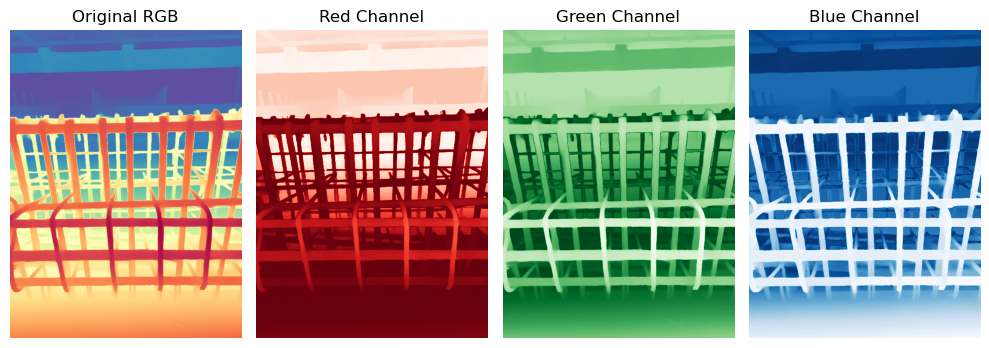

In [157]:
depth_map = cv.imread('depth_map_comparison/0.5m_pred/depth_anything_vitl/20250502_132954.png', cv.IMREAD_COLOR)
depth_map = cv.cvtColor(depth_map, cv.COLOR_BGR2RGB)  # Convert BGR to RGB
depth_map = cv.normalize(depth_map, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)

red_channel = depth_map[:,:,0]
green_channel = depth_map[:,:,1] 
blue_channel = depth_map[:,:,2]

# Let's examine which channel has the most depth variation
plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.imshow(depth_map)
plt.title('Original RGB')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(red_channel, cmap='Reds')
plt.title('Red Channel')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(green_channel, cmap='Greens')
plt.title('Green Channel')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(blue_channel, cmap='Blues')
plt.title('Blue Channel')
plt.axis('off')

plt.tight_layout()
plt.show()

It seems that blue has the better representation of segmenting the closer bars.  

Next steps: 
- Try to get the shape of the bar by setting a thresholds

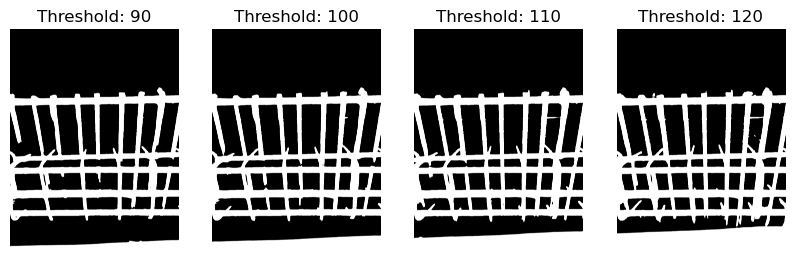

In [158]:
plt.figure(figsize=(10, 5))
thresholds = [90, 100, 110, 120]
for i in range(len(thresholds)):
    _, bar = cv.threshold(blue_channel, thresholds[i], 255, cv.THRESH_BINARY_INV)
    
    plt.subplot(1, len(thresholds), i + 1)
    plt.imshow(bar, cmap='gray')
    plt.title(f'Threshold: {thresholds[i]}')
    plt.axis('off')

I think by setting `threshold=110` captures the better representation of the bar, it shows the two layers of bar but without too many miscellaneous details.  

Next steps:
- Background Removal
- Try to segment the first and second layer.
- Set the two layers into different images

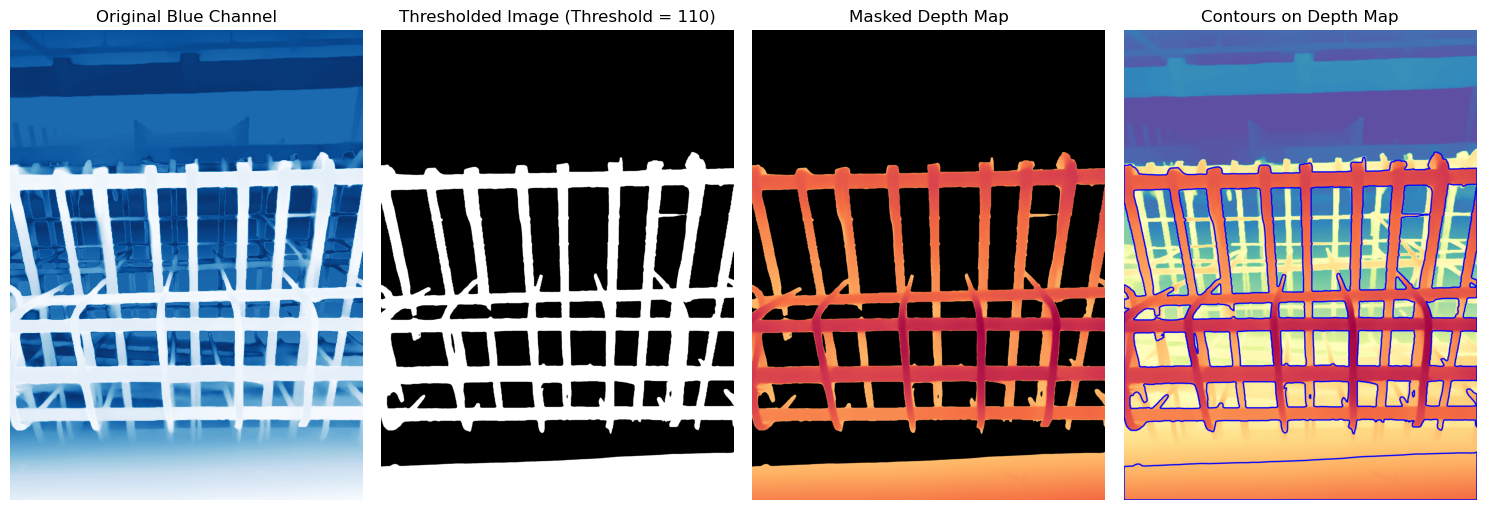

In [159]:
_, thresh = cv.threshold(blue_channel, 110, 255, cv.THRESH_BINARY_INV)
contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

depth_map_masked = cv.bitwise_and(depth_map, depth_map, mask=thresh)

depth_map_with_contours = depth_map.copy()
cv.drawContours(depth_map_with_contours, contours, -1, (0, 0, 255), 10, cv.LINE_AA)

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(blue_channel, cmap='Blues')
plt.title('Original Blue Channel')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(thresh, cmap='gray')
plt.title('Thresholded Image (Threshold = 110)')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(depth_map_masked)
plt.title('Masked Depth Map')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(depth_map_with_contours)
plt.title('Contours on Depth Map')
plt.axis('off')

plt.tight_layout()
plt.show()

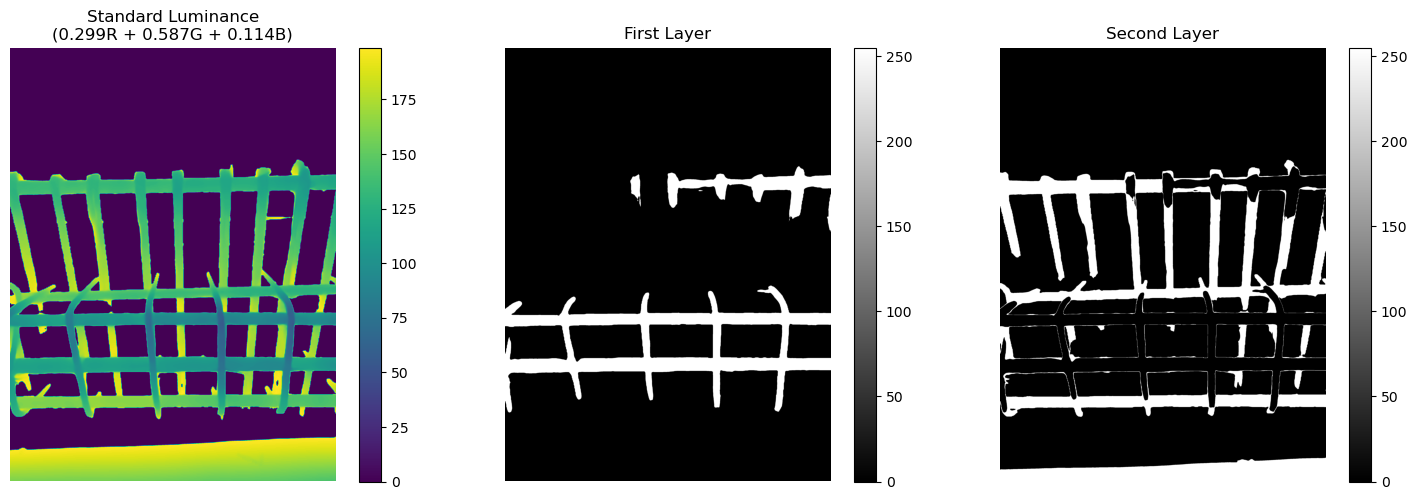

In [160]:
plt.figure(figsize=(15, 5))
ncols = 3

luminance = 0.299 * depth_map_masked[:,:,0] + 0.587 * depth_map_masked[:,:,1] + 0.114 * depth_map_masked[:,:,2]
plt.subplot(1, ncols, 1)
plt.imshow(luminance)
plt.title('Standard Luminance\n(0.299R + 0.587G + 0.114B)')
plt.colorbar()
plt.axis('off')

first_layer_range = (luminance >= 25) & (luminance < 125)
first_layer = first_layer_range.astype(np.uint8) * 255
plt.subplot(1, ncols, 2)
plt.imshow(first_layer, cmap='gray')
plt.title('First Layer')
plt.colorbar()
plt.axis('off')

second_layer_range = (luminance >= 125) & (luminance < 175)
second_layer = second_layer_range.astype(np.uint8) * 255
plt.subplot(1, ncols, 3)
plt.imshow(second_layer, cmap='gray')
plt.title('Second Layer')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

As you can see, the second layer is ugly due to depth detection

Next Steps:
- try to smooth out the edges using blur (https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html)
- try to use k-means as threshold (https://docs.opencv.org/4.x/d1/d5c/tutorial_py_kmeans_opencv.html)

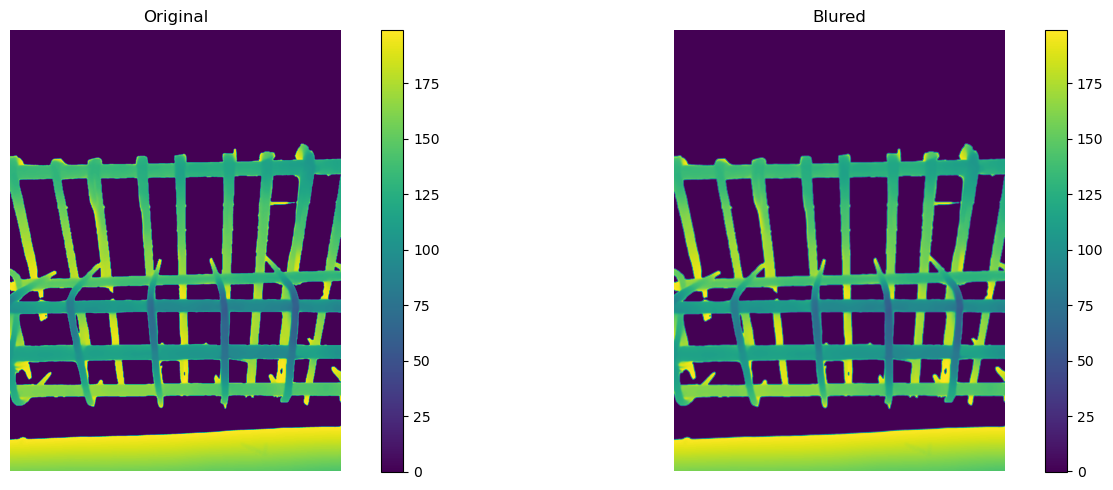

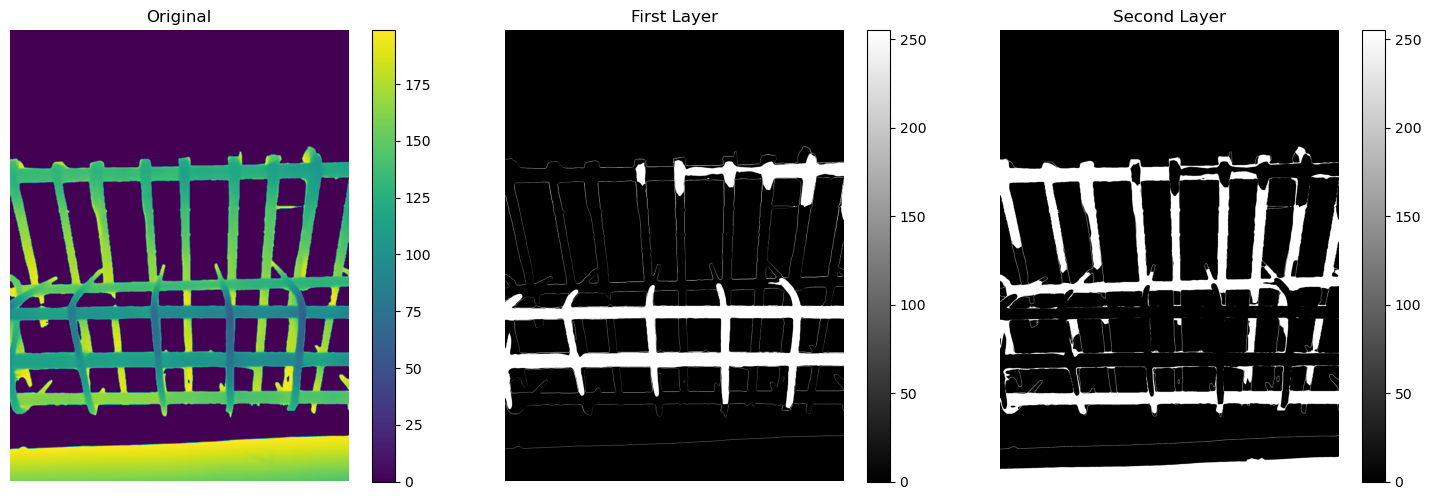

In [164]:
# apply blur
kernel = np.ones((10, 10), np.float32) / 100
depth_map_blurred = cv.filter2D(luminance, -1, kernel)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(luminance)
plt.title('Original')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(depth_map_blurred)
plt.title('Blured')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


# segment the two layers
depth_map_blurred = cv.bitwise_and(depth_map_blurred, depth_map_blurred, mask=thresh)

plt.figure(figsize=(15, 5))
ncols = 3

plt.subplot(1, ncols, 1)
plt.imshow(depth_map_blurred)
plt.title('Original')
plt.colorbar()
plt.axis('off')

first_layer_range = (depth_map_blurred >= 25) & (depth_map_blurred < 125)  # Use & instead of and
first_layer = first_layer_range.astype(np.uint8) * 255
plt.subplot(1, ncols, 2)
plt.imshow(first_layer, cmap='gray')
plt.title('First Layer')
plt.colorbar()
plt.axis('off')

second_layer_range = (depth_map_blurred >= 125) & (depth_map_blurred < 175)
second_layer = second_layer_range.astype(np.uint8) * 255
plt.subplot(1, ncols, 3)
plt.imshow(second_layer, cmap='gray')
plt.title('Second Layer')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


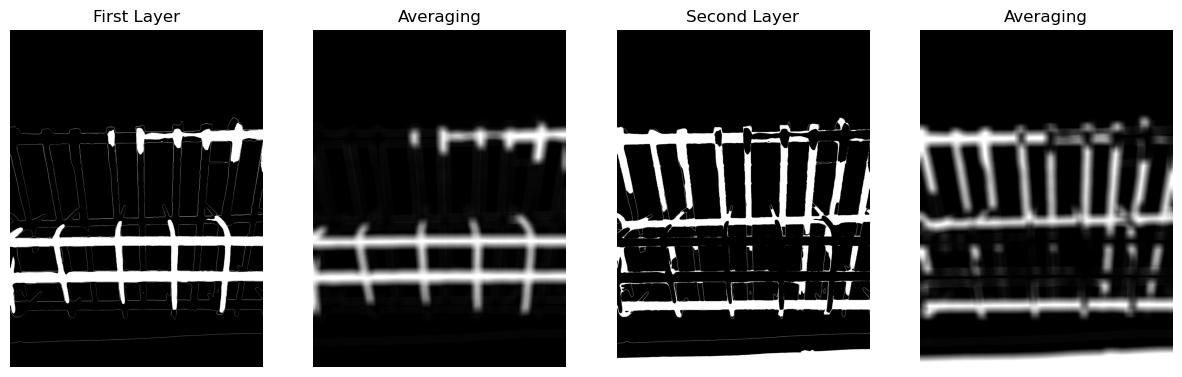

In [162]:
kernel = np.ones((100,100), np.float32) / 10000
first_layer_blur = cv.filter2D(first_layer,-1,kernel)

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(first_layer, cmap='gray'),plt.title('First Layer')
plt.axis('off')

plt.subplot(1, 4, 2),plt.imshow(first_layer_blur, cmap='gray'),plt.title('Averaging')
plt.axis('off')


second_layer_blur = cv.filter2D(second_layer,-1,kernel)

plt.subplot(1, 4, 3)
plt.imshow(second_layer, cmap='gray'),plt.title('Second Layer')
plt.axis('off')

plt.subplot(1, 4, 4),plt.imshow(second_layer_blur, cmap='gray'),plt.title('Averaging')
plt.axis('off')

plt.tight_layout
plt.show()

Find corners using the threshold image

/var/folders/8r/0dvmj4y505gbvfv579p6fdxm0000gn/T/ipykernel_3574/215023116.py:12: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


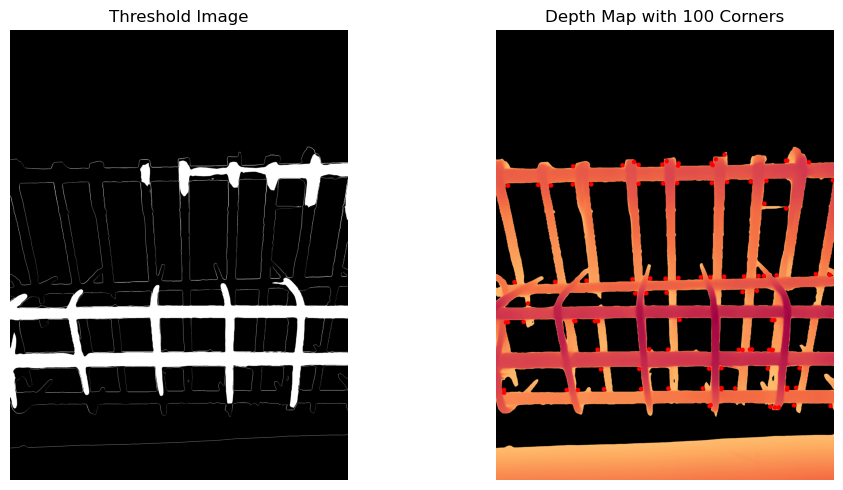

In [163]:
plt.figure(figsize=(15, 5))
ncols = 3

# First subplot - show threshold image
plt.subplot(1, ncols, 1)
plt.imshow(first_layer, cmap='gray')
plt.title('Threshold Image')
plt.axis('off')

# Detect corners
corners = cv.goodFeaturesToTrack(first_layer, maxCorners=100, qualityLevel=0.01, minDistance=10, blockSize=50)
corners = np.int0(corners)

# Create a copy of depth_map to draw corners on
depth_map_with_corners = depth_map_masked.copy()

for corner in corners:
    x, y = corner.ravel()
    cv.circle(depth_map_with_corners, (x, y), 20, (255, 0, 0), -1)  # Red circles, bigger size

# Second subplot - show depth map with corners (RGB, not grayscale)
plt.subplot(1, ncols, 2)
plt.imshow(depth_map_with_corners)  # Remove cmap='gray' for RGB image
plt.title(f'Depth Map with {len(corners)} Corners')
plt.axis('off')

plt.tight_layout()
plt.show()